## Customer Cohort Analysis

**Goal**: Determine which accounts up for renewal in Q4-2021 we can target to engage in consistent Great health over the next 12 months.

**Definitions**: An account in Great health at least 75% over a given time period (minimum 4 months) is deemed to be **consistently** in Great health

In [1]:
import datetime
import string
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from salesforce.client import Salesforce
from searchlight.db import Config

warnings.filterwarnings('ignore')
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200

In [2]:
sf = Salesforce()
config = Config()

bin_lookup = {'00000': 'A', '00001': 'B', '00010': 'C', '00011': 'D', '00100': 'E', '00101': 'F', '00110': 'G',
              '00111': 'H', '01000': 'I', '01001': 'J', '01010': 'K', '01011': 'L', '01100': 'M', '01101': 'N',
              '01110': 'O', '01111': 'P', '10000': 'Q', '10001': 'R', '10010': 'S', '10011': 'T', '10100': 'U',
              '10101': 'V', '10110': 'W', '10111': 'X', '11000': 'Y', '11001': 'Z', '11010': '0', '11011': '1',
              '11100': '2', '11101': '3', '11110': '4', '11111': '5'}

In [3]:
def pull_data(date_filter):
    """
    :param str date_filter: YYYY-MM-DD
    :return:
    """
    target_customers = query_to_df(sf.query_all(health_score_query(date_filter)))
    conductor_active_users = config.query(conductor_active_users_query())
    set_conductor_active_users_columns(conductor_active_users)
    active_sf_contacts = query_to_df(sf.query_all(active_sf_contacts_query()))
    active_sf_contacts = transform_sf_contacts(active_sf_contacts)
    report = build_report(target_customers, conductor_active_users, active_sf_contacts)
    report.to_excel("/users/akim/documents/cohort_analysis/FQ22 CDP KPI Research {}.xlsx".format(
        datetime.datetime.now()), index=False)
    return report


def sf_id_15_to_18(sfdc_id):

    if len(sfdc_id) == 18:
        return sfdc_id

    # split into list of 3 5-character chunks
    id_chunks = map("".join, zip(*[iter(sfdc_id)]*5))

    suffix = ''

    for id_chunk in id_chunks:

        # replace all capital letters with 1, non cap letters with 0
        lookup_components = [sf_replace(id_char) for id_char in id_chunk]

        # make it string and reverse it
        lookup_chunk = "".join(lookup_components)[::-1]

        # get the letter from the lookup table based on the reversed string
        bin_replacement = bin_lookup[lookup_chunk]
        suffix += bin_replacement

    # add the suffix to the original id
    expanded_sfdc_id = sfdc_id + suffix

    return expanded_sfdc_id


def sf_replace(incoming_id_char):

    if incoming_id_char in string.ascii_uppercase:
        return '1'
    else:
        return '0'


def query_to_df(data):
    return pd.DataFrame(data["records"]).drop("attributes", axis=1)


def target_customers_filter(df):
    return df[df.Health_Score_Actual__c != "Great"]


def health_score_query(date_filter):
    return """SELECT Id, Account_Name__c, Health_Version__c, Orchestra_Tier__c, Expected_Percent__c, 
    Health_Date__c, Agency_Health_Tier__c, Active_Searchlight_Accounts__c, In_Platform_Activities__c, 
    Time_Spent_in_Platform__c, Active_Days__c, Active_Users__c, Customer_Since__c, Health_Score_Actual__c, 
    Health_Score_Comp__c, Hold_Reason__c, Health_ACV__c, Health_Snapshot_SSM__c, Health_Snapshot_Manager__c, 
    Health_Snapshot_Director__c, Health_Snapshot_VP__c, Health_Record_Name__c, Projected_Percent__c, Expected_ACV__c, 
    Projected_ACV__c, Health_Snapshot_AD__c 
    FROM Health_Score__c WHERE Health_Date__c > {} AND Health_ACV__c > 0""".format(date_filter)


def conductor_active_users_query():
    return "SELECT a.salesforce_id, COUNT(DISTINCT u.id) " \
           "FROM users u JOIN group_members gm on u.id = gm.user_id " \
           "JOIN groups g on gm.group_id = g.id JOIN accounts a on a.group_id = g.id " \
           "WHERE u.status = 1 AND a.status_id = 1 AND u.email NOT LIKE '%%@conductor.com' " \
           "GROUP BY a.salesforce_id"


def active_sf_contacts_query():
    return "SELECT Id, SFDC_Account_ID__c FROM Contact WHERE SL_Active_Status__c = True"


def sf_q4_customers_query():
    return "SELECT Id, Name, Renewal_Date_New__c, Aggregated_ACV__c FROM Account " \
           "WHERE RecordTypeId = \'01260000000UJm7AAG\' AND Renewal_Date_New__c < 2022-01-31 " \
           "AND Renewal_Date_New__c > 2021-10-31"


def set_conductor_active_users_columns(conductor_active_users):
    conductor_active_users.columns = ["Account_Name__c", "searchlight_count_unique_users"]


def build_report(target_customers, conductor_active_users, active_sf_contacts):
    report = target_customers.merge(conductor_active_users, on="Account_Name__c", how="left")
    report = report.merge(active_sf_contacts, on="Account_Name__c", how="left")
    report.rename(columns={"unique_users": "searchlight_count_unique_users"}, inplace=True)
    report.drop(0, inplace=True)
    report.searchlight_count_unique_users.fillna(0, inplace=True)
    report.salesforce_count_unique_users.fillna(0, inplace=True)
    report.drop(
        columns=[
            "Id", "Expected_Percent__c", "Agency_Health_Tier__c", "Health_Score_Comp__c",
            "Hold_Reason__c", "Health_Snapshot_SSM__c", "Health_Snapshot_Manager__c", "Health_Snapshot_Director__c",
            "Health_Snapshot_VP__c", "Health_Record_Name__c", "Projected_Percent__c", "Health_Snapshot_AD__c"
        ], inplace=True
    )
    report.rename(columns={c: c.replace("__c", "").replace("_", " ") for c in report.columns}, inplace=True)
    report.rename(
        columns={
            "Account Name": "Salesforce Account ID",
            "searchlight count unique users": "searchlight count unique users".title(),
            "salesforce count unique users": "salesforce count unique users".title()}, inplace=True)
    return report


def transform_sf_contacts(active_sf_contacts):
    active_sf_contacts = active_sf_contacts[~active_sf_contacts.SFDC_Account_ID__c.isnull()]
    active_sf_contacts.SFDC_Account_ID__c = active_sf_contacts.SFDC_Account_ID__c.apply(sf_id_15_to_18)
    active_sf_contacts = active_sf_contacts.groupby("SFDC_Account_ID__c")["Id"].nunique().reset_index().rename(
        columns={"SFDC_Account_ID__c": "Account_Name__c", "Id": "salesforce_count_unique_users"})
    active_sf_contacts.rename(
        columns={"SFDC_Account_ID__c": 'Account_Name__c'}, inplace=True)
    return active_sf_contacts

## Data Collection/Cleaning

1. Determine all accounts up for renewal in Q4-2021
2. Collect health data for the past 12 months for these accounts

In [4]:
# Collect Q4-2021 customers
q4_renewals = query_to_df(sf.query_all(sf_q4_customers_query()))
q4_renewals.rename(columns={c: c.replace("__c", "").replace("_", " ") for c in q4_renewals.columns}, inplace=True)

In [5]:
q4_renewals.shape

(76, 4)

In [6]:
q4_renewals.head()

,Id,Name,Renewal Date New,Aggregated ACV
0,0013g000002O5l8AAC,Citi International Personal Bank,2021-12-31,100000.0
1,0013g000002Nt1VAAS,Spring Venture Group,2021-11-01,30000.0
2,0013g000002Nu0eAAC,LT Apparel Group,2021-12-31,41000.0
3,0010d00001KIsxAAAT,StockX LLC,2022-01-12,325000.0
4,0010d00001J7HVNAA3,Logic Technology Development LLC,2021-12-31,75800.0


In [7]:
# Collect usage data since 2020-04
usage_data = pull_data('2020-04-01')

In [8]:
usage_data = usage_data[usage_data['Health Date'] != '2020-04-20']

In [9]:
# Filter to Q4-2021 renewal customers
q4_renewal_ids = q4_renewals.Id.unique().tolist()

usage_data = usage_data[usage_data['Salesforce Account ID'].isin(q4_renewal_ids)]

In [10]:
usage_data.sort_values(['Salesforce Account ID', 'Health Date'], inplace=True)

In [11]:
usage_data.head()

,Salesforce Account ID,Health Version,Orchestra Tier,Health Date,Active Searchlight Accounts,In Platform Activities,Time Spent in Platform,Active Days,Active Users,Customer Since,Health Score Actual,Health ACV,Expected ACV,Projected ACV,Searchlight Count Unique Users,Salesforce Count Unique Users
5699,0010d00001J7HVNAA3,Health 2.0 - Direct,None,2020-05-01,1.0,295.0,85.0,7.0,2.0,2018-01-01,Poor,75800.0,0.0,0.0,8.0,7.0
6132,0010d00001J7HVNAA3,Health 2.0 - Direct,None,2020-06-01,1.0,112.0,122.0,2.0,1.0,2018-01-01,Poor,75800.0,0.0,0.0,8.0,7.0
501,0010d00001J7HVNAA3,Health 2.0 - Direct,None,2020-07-01,1.0,326.0,81.0,5.0,2.0,2018-01-01,Poor,75800.0,0.0,0.0,8.0,7.0
1080,0010d00001J7HVNAA3,Health 3.0 - Direct,Silver,2020-08-01,1.0,309.0,87.0,4.0,2.0,2018-01-01,Poor,75800.0,56092.0,22740.0,8.0,7.0
4710,0010d00001J7HVNAA3,Health 3.0 - Direct,Gold,2020-09-01,1.0,495.0,124.0,7.0,3.0,2018-01-01,Average,75800.0,59882.0,53060.0,8.0,7.0


In [12]:
# Merge datasets
q4_customers_df = pd.merge(usage_data, q4_renewals, 
                           left_on='Salesforce Account ID', right_on='Id').drop(['Id'], axis=1)

In [13]:
q4_customers_df.drop_duplicates(['Salesforce Account ID', 'Health Date'], inplace=True)

In [14]:
q4_customers_df.head(12)

,Salesforce Account ID,Health Version,Orchestra Tier,Health Date,Active Searchlight Accounts,In Platform Activities,Time Spent in Platform,Active Days,Active Users,Customer Since,Health Score Actual,Health ACV,Expected ACV,Projected ACV,Searchlight Count Unique Users,Salesforce Count Unique Users,Name,Renewal Date New,Aggregated ACV
0,0010d00001J7HVNAA3,Health 2.0 - Direct,None,2020-05-01,1.0,295.0,85.0,7.0,2.0,2018-01-01,Poor,75800.0,0.0,0.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0
1,0010d00001J7HVNAA3,Health 2.0 - Direct,None,2020-06-01,1.0,112.0,122.0,2.0,1.0,2018-01-01,Poor,75800.0,0.0,0.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0
2,0010d00001J7HVNAA3,Health 2.0 - Direct,None,2020-07-01,1.0,326.0,81.0,5.0,2.0,2018-01-01,Poor,75800.0,0.0,0.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0
3,0010d00001J7HVNAA3,Health 3.0 - Direct,Silver,2020-08-01,1.0,309.0,87.0,4.0,2.0,2018-01-01,Poor,75800.0,56092.0,22740.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0
4,0010d00001J7HVNAA3,Health 3.0 - Direct,Gold,2020-09-01,1.0,495.0,124.0,7.0,3.0,2018-01-01,Average,75800.0,59882.0,53060.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0
5,0010d00001J7HVNAA3,Health 3.0 - Direct,Gold,2020-10-01,1.0,274.0,90.0,8.0,4.0,2018-01-01,Average,75800.0,59882.0,53060.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0
6,0010d00001J7HVNAA3,Health 3.0 - Direct,Gold,2020-11-01,1.0,181.0,62.0,7.0,2.0,2018-01-01,Poor,75800.0,59882.0,22740.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0
7,0010d00001J7HVNAA3,Health 3.0 - Direct,Gold,2020-12-01,1.0,91.0,41.0,3.0,3.0,2018-01-01,Poor,75800.0,59882.0,22740.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0
8,0010d00001J7HVNAA3,Health 3.0 - Direct,Gold,2021-01-01,1.0,344.0,147.0,7.0,3.0,2018-01-01,Average,75800.0,59882.0,53060.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0
9,0010d00001J7HVNAA3,Health 3.0 - Direct,Gold,2021-02-01,1.0,19.0,12.0,2.0,3.0,2018-01-01,Poor,75800.0,59882.0,22740.0,8.0,7.0,Logic Technology Development LLC,2021-12-31,75800.0


## Data Transformation

1. Retroactively apply V3.0 grading (when Great health was introduced)
2. Calculate trailing health score average as a measure of rolling account health per month where:
    * 1 = Poor
    * 2 = Average
    * 3 = Good
    * 4 = Great
3. Calculate percentage of time spent in Great health per account (and other health categories)
4. Transform into desired format

In [15]:
def return_v3_account_health(users, minutes, days):
    if users < 2 or minutes < 90 or days < 3:
        return 'Poor'
    elif users >= 4 and users < 6 and minutes >= 325 and days >= 6:
        return 'Good'
    elif users >= 6 and minutes >= 325 and days >= 6:
        return 'Great'
    else:
        return 'Average'

In [16]:
q4_customers_df['Health Score Actual'].value_counts()

Average    264
Good       189
Great      179
Poor       179
Name: Health Score Actual, dtype: int64

In [17]:
# Apply V3.0 grading
q4_customers_df['Health Score Actual'] = q4_customers_df.apply(
    lambda x: return_v3_account_health(x['Active Users'], x['Time Spent in Platform'], x['Active Days']) 
    if x['Health Version'] == 'Health 2.0 - Direct' else x['Health Score Actual'], axis=1)

In [18]:
q4_customers_df['Health Score Actual'].value_counts()

Average    264
Great      231
Poor       179
Good       137
Name: Health Score Actual, dtype: int64

In [19]:
q4_customers_df[(q4_customers_df['Health Version']=='Health 2.0 - Direct') &
                (q4_customers_df['Health Score Actual']=='Great')].head()

,Salesforce Account ID,Health Version,Orchestra Tier,Health Date,Active Searchlight Accounts,In Platform Activities,Time Spent in Platform,Active Days,Active Users,Customer Since,Health Score Actual,Health ACV,Expected ACV,Projected ACV,Searchlight Count Unique Users,Salesforce Count Unique Users,Name,Renewal Date New,Aggregated ACV
16,0010d00001KIsxAAAT,Health 2.0 - Direct,None,2020-05-01,2.0,4575.0,1396.0,20.0,10.0,2020-01-13,Great,162500.0,0.0,0.0,57.0,56.0,StockX LLC,2022-01-12,325000.0
18,0010d00001KIsxAAAT,Health 2.0 - Direct,None,2020-06-01,2.0,11500.0,2921.0,24.0,18.0,2020-01-13,Great,162500.0,0.0,0.0,57.0,56.0,StockX LLC,2022-01-12,325000.0
20,0010d00001KIsxAAAT,Health 2.0 - Direct,None,2020-07-01,2.0,5706.0,1711.0,24.0,20.0,2020-01-13,Great,162500.0,0.0,0.0,57.0,56.0,StockX LLC,2022-01-12,325000.0
44,0010d00001KdUYhAAN,Health 2.0 - Direct,None,2020-06-01,1.0,3858.0,1164.0,19.0,10.0,2020-01-01,Great,99994.0,0.0,0.0,18.0,18.0,Lifespan,2021-12-31,99994.0
45,0010d00001KdUYhAAN,Health 2.0 - Direct,None,2020-07-01,1.0,2509.0,925.0,20.0,8.0,2020-01-01,Great,99994.0,0.0,0.0,18.0,18.0,Lifespan,2021-12-31,99994.0


In [20]:
# Trailing health calculation
account_health_mapping={'Poor': 1, 'Average': 2, 'Good': 3, 'Great': 4}
q4_customers_df['Health Score Value'] = q4_customers_df.apply(
    lambda x: account_health_mapping[x['Health Score Actual']], axis=1)

In [21]:
q4_customers_df['Trailing Health Score'] = q4_customers_df.groupby('Name')['Health Score Value'].transform(
    lambda x: x.rolling(12, 1).mean())
q4_customers_df['Trailing Month Count'] = q4_customers_df.groupby('Name')['Health Score Value'].transform(
    lambda x: x.rolling(12, 1).count())

In [22]:
q4_customers_df[['Name', 'Health Date', 'Health Score Actual', 'Health Score Value', 
                 'Trailing Health Score', 'Trailing Month Count']].head(12)

,Name,Health Date,Health Score Actual,Health Score Value,Trailing Health Score,Trailing Month Count
0,Logic Technology Development LLC,2020-05-01,Poor,1,1.000000,1
1,Logic Technology Development LLC,2020-06-01,Poor,1,1.000000,2
2,Logic Technology Development LLC,2020-07-01,Poor,1,1.000000,3
3,Logic Technology Development LLC,2020-08-01,Poor,1,1.000000,4
4,Logic Technology Development LLC,2020-09-01,Average,2,1.200000,5
5,Logic Technology Development LLC,2020-10-01,Average,2,1.333333,6
6,Logic Technology Development LLC,2020-11-01,Poor,1,1.285714,7
7,Logic Technology Development LLC,2020-12-01,Poor,1,1.250000,8
8,Logic Technology Development LLC,2021-01-01,Average,2,1.333333,9
9,Logic Technology Development LLC,2021-02-01,Poor,1,1.300000,10


In [23]:
# Pivot into desired format
q4_customers_pivot = q4_customers_df.pivot(index='Name', columns='Health Date', values='Trailing Health Score').reset_index()

In [24]:
q4_customers_pivot.head()

Health Date,Name,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01
0,Acronym Media on Behalf of Bath & Body Works,3.0,3.0,3.000000,3.00,3.0,3.000000,3.000000,2.875,2.888889,2.9,2.909091,2.833333
1,Aggreko,2.0,1.5,1.666667,1.75,1.6,1.666667,1.571429,1.500,1.444444,1.4,1.363636,1.333333
2,"Ally Financial, Inc.",2.0,2.0,1.666667,1.75,2.0,2.166667,2.142857,2.125,2.111111,2.2,2.181818,2.166667
3,"American Girl Brands, LLC",1.0,1.0,1.000000,1.50,1.8,1.833333,1.857143,1.875,1.888889,1.9,1.909091,1.916667
4,Apex Capital Corp,2.0,2.0,2.333333,2.50,2.6,2.500000,2.428571,2.375,2.333333,2.4,2.454545,2.500000


In [25]:
q4_customers_last_month = q4_customers_df.drop_duplicates('Name', keep='last')

In [26]:
q4_customers_health_distribution = q4_customers_df.groupby('Name')['Health Score Actual'].value_counts(
    normalize=True).unstack().reset_index()

In [27]:
q4_customers_health_distribution.head()

Health Score Actual,Name,Average,Good,Great,Poor
0,Acronym Media on Behalf of Bath & Body Works,0.166667,0.833333,NaN,NaN
1,Aggreko,0.333333,NaN,NaN,0.666667
2,"Ally Financial, Inc.",0.666667,0.250000,NaN,0.083333
3,"American Girl Brands, LLC",0.583333,0.166667,NaN,0.250000
4,Apex Capital Corp,0.500000,0.500000,NaN,NaN


In [28]:
# Add on number of score distribution, total months and other desired account info
q4_customers_pivot = pd.merge(q4_customers_pivot, q4_customers_health_distribution[['Name', 'Great', 'Good', 'Average', 'Poor']], on='Name')
q4_customers_pivot = pd.merge(q4_customers_pivot, q4_customers_last_month[['Trailing Month Count', 'Searchlight Count Unique Users', 'Aggregated ACV', 'Renewal Date New', 'Salesforce Account ID', 'Name']], on='Name')

In [29]:
# Rename columns and fill nulls
q4_customers_pivot.rename({'Great': 'Great Percent', 'Good': 'Good Percent', 'Average': 'Average Percent',
                           'Poor': 'Poor Percent', 'Trailing Month Count': 'Total Months',
                           'Searchlight Count Unique Users': 'Active Logins'}, axis=1, inplace=True)
q4_customers_pivot.update(q4_customers_pivot[['Great Percent', 'Good Percent', 'Average Percent', 'Poor Percent']].fillna(0))

In [30]:
q4_customers_pivot.head()

,Name,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,...,2021-04-01,Great Percent,Good Percent,Average Percent,Poor Percent,Total Months,Active Logins,Aggregated ACV,Renewal Date New,Salesforce Account ID
0,Acronym Media on Behalf of Bath & Body Works,3.0,3.0,3.000000,3.00,3.0,3.000000,3.000000,2.875,2.888889,...,2.833333,0.0,0.833333,0.166667,0.000000,12,21.0,47750.0,2021-11-30,0016000000HCmknAAD
1,Aggreko,2.0,1.5,1.666667,1.75,1.6,1.666667,1.571429,1.500,1.444444,...,1.333333,0.0,0.000000,0.333333,0.666667,12,6.0,54890.0,2021-12-31,0016000000cY2lFAAS
2,"Ally Financial, Inc.",2.0,2.0,1.666667,1.75,2.0,2.166667,2.142857,2.125,2.111111,...,2.166667,0.0,0.250000,0.666667,0.083333,12,5.0,30000.0,2021-12-10,0016000000LlNQKAA3
3,"American Girl Brands, LLC",1.0,1.0,1.000000,1.50,1.8,1.833333,1.857143,1.875,1.888889,...,1.916667,0.0,0.166667,0.583333,0.250000,12,21.0,95000.0,2021-12-31,0016000000GF0XiAAL
4,Apex Capital Corp,2.0,2.0,2.333333,2.50,2.6,2.500000,2.428571,2.375,2.333333,...,2.500000,0.0,0.500000,0.500000,0.000000,12,15.0,42000.0,2021-11-22,0016000000y3xifAAA


## Customer Segmentation

We will now use the most recent trailing average and percentage of time in Great health for segmentation (active logins also included for now). 

Great health percentage tells us consistency and trailing average gives a measure of variance (where is the account when not in Great health?)
* For example, if you spend 50% of the time in Great but the other 50% in Poor, your trailing average will be 2.5 and   your health has high variance (not reliable for enough for high likelihood)

**Proposed Segmentations** - likelihood of engaging consistent Great account health
* **Consistently in Great health** - customers who have 75%+ time in Great health (must also have more than 4 total months)
* **High Likelihood** - customers who have been in Great at least 50% of the time AND 3.0+ trailing average AND have 6 or more active logins
* **Medium likelihood** - customers who have been in Great at least 25% of the time AND 2.5+ trailing average AND have 6 or more active logins
* **Low likelihood** - Not poor, medium or high
* **Poor likelihood** - customers who have never been in Great health AND <=2.0 trailing average OR less than 4 active logins


In [31]:
def return_customer_segment(trailing_average, great_percent, active_logins, total_months):
    if trailing_average <= 2 and great_percent == 0 or active_logins < 4:
        return 'Poor likelihood'
    elif great_percent >= 0.75 and total_months >= 4:
        return 'Consistently in Great health'
    elif trailing_average >= 3 and great_percent >= 0.5 and active_logins >= 6:
        return 'High likelihood'
    elif trailing_average >= 2.5 and great_percent >= 0.25 and active_logins >= 6:
        return 'Medium likelihood'
    else:
        return 'Low likelihood'

In [32]:
q4_customers_pivot['Customer Segment'] = q4_customers_pivot.apply(
    lambda x: return_customer_segment(x['2021-04-01'], x['Great Percent'], 
                                      x['Active Logins'], x['Total Months']), axis=1)

## Results

In [33]:
segment_ordering = ['Consistently in Great health', 'High likelihood', 'Medium likelihood', 'Low likelihood', 
                    'Poor likelihood']
q4_customers_pivot['Customer Segment'] = pd.Categorical(q4_customers_pivot['Customer Segment'], segment_ordering)

In [34]:
q4_customers_pivot.sort_values(['Customer Segment', 'Aggregated ACV'], ascending=[1, 0], inplace=True)

In [35]:
q4_customers_pivot.head()

,Name,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,...,Great Percent,Good Percent,Average Percent,Poor Percent,Total Months,Active Logins,Aggregated ACV,Renewal Date New,Salesforce Account ID,Customer Segment
49,PMI Inc.,4.0,4.0,4.0,3.75,3.8,3.833333,3.857143,3.875,3.888889,...,0.916667,0.083333,0.0,0.0,12,379.0,2000000.0,2021-12-31,0016000000N4cKhAAJ,Consistently in Great health
14,Citigroup Inc.,4.0,4.0,4.0,3.75,3.8,3.833333,3.857143,3.875,3.888889,...,0.916667,0.083333,0.0,0.0,12,152.0,985500.0,2021-12-31,0016000000Ey23fAAB,Consistently in Great health
58,SAP Global Marketing,4.0,4.0,4.0,3.75,3.8,3.833333,3.857143,3.875,3.888889,...,0.916667,0.083333,0.0,0.0,12,609.0,488300.0,2021-12-31,0016000000HglVKAAZ,Consistently in Great health
50,Pacific Dental Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000,3.000000,...,0.800000,0.000000,0.2,0.0,5,53.0,340000.0,2021-12-31,0016000000xCU5CAAW,Consistently in Great health
66,StockX LLC,4.0,4.0,4.0,3.75,3.8,3.833333,3.857143,3.875,3.888889,...,0.916667,0.083333,0.0,0.0,12,57.0,325000.0,2022-01-12,0010d00001KIsxAAAT,Consistently in Great health


In [37]:
df_agg = q4_customers_pivot.groupby('Customer Segment').agg({'Aggregated ACV': sum, 'Name': 'count'})

In [38]:
df_agg.reset_index(inplace=True)

In [40]:
df_agg

,Customer Segment,Aggregated ACV,Name
0,Consistently in Great health,5278040.00,15
4,Poor likelihood,1747657.42,26
1,High likelihood,1393494.00,8
3,Low likelihood,1352343.00,19
2,Medium likelihood,654140.00,8


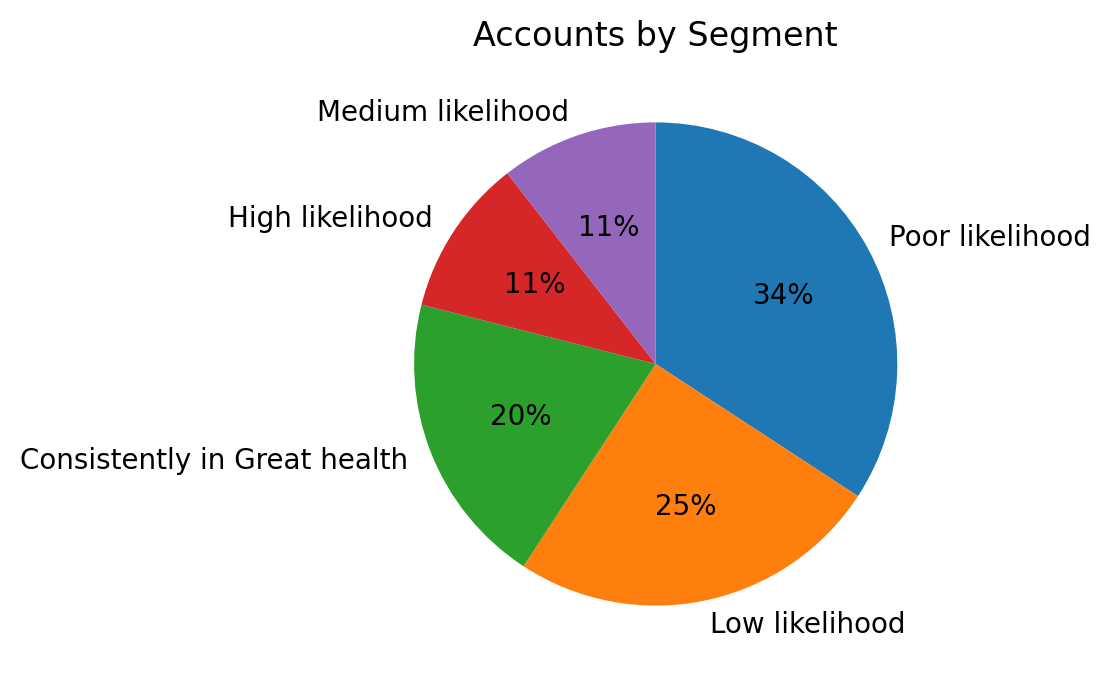

In [45]:
df_agg.sort_values(['Name'], ascending=False, inplace=True)
plt.pie(df_agg['Name'], labels=df_agg['Customer Segment'], 
       autopct='%1.0f%%', startangle=90, counterclock=False)
plt.title('Accounts by Segment')
plt.show()

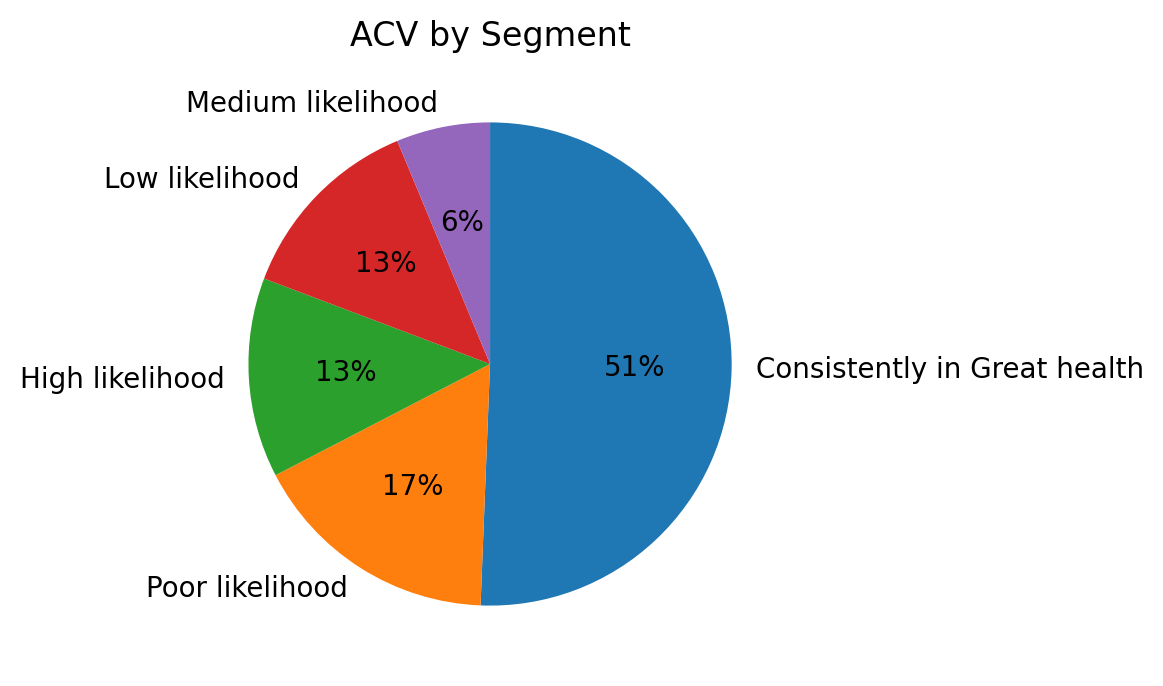

In [47]:
df_agg.sort_values(['Aggregated ACV'], ascending=False, inplace=True)
plt.pie(df_agg['Aggregated ACV'], labels=df_agg['Customer Segment'], 
       autopct='%1.0f%%', startangle=90, counterclock=False)
plt.title('ACV by Segment')
plt.show()

In [46]:
q4_customers_pivot[['Name', 'Customer Segment', 'Aggregated ACV']]

,Name,Customer Segment,Aggregated ACV
49,PMI Inc.,Consistently in Great health,2000000.00
14,Citigroup Inc.,Consistently in Great health,985500.00
58,SAP Global Marketing,Consistently in Great health,488300.00
50,Pacific Dental Services,Consistently in Great health,340000.00
66,StockX LLC,Consistently in Great health,325000.00
5,"Audible, Inc.",Consistently in Great health,198000.00
12,Chubb Corporation,Consistently in Great health,190000.00
53,Philips,Consistently in Great health,180000.00
72,Unisys Corporation,Consistently in Great health,136840.00
28,"Gannett Media Corp. f/k/a Gannett Co., Inc.",Consistently in Great health,94400.00
